# Imports

In [1]:
import sys
import optuna
import mlflow
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold


sys.path.insert(1, '../scripts')
from silhouette_score import get_silhouette_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Gerando as funções de treinamento

In [2]:
def train_linear_regression(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"LINEAR REGRESSION: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    LinearRegressionParams = {
        "fit_intercept": [True, False],
        "copy_X": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in LinearRegressionParams.items()}

        with mlflow.start_run():
            model = LinearRegression(**model_params, n_jobs=-1)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/LinearRegressionParams_{test_name}_study.csv')

In [3]:
def train_ridge(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RIDGE: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RidgeRegressionParams = {
        "alpha": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
        "fit_intercept": [True, False],
        "copy_X": [True, False],
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RidgeRegressionParams.items()}

        with mlflow.start_run():
            model = Ridge(**model_params, random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')

            return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/Ridge_{test_name}_study.csv')

In [4]:
def train_SVR(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"SVR: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    SVRParams = {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf"],
        "degree": [2, 3, 5],
        "gamma": ["scale", "auto"],
        "coef0": [0.0, 0.5, 1.0, 5.0]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in SVRParams.items()}

        with mlflow.start_run():
            # Limitando pois é um treinamento demorado
            model = SVR(**model_params, max_iter=500)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/SVR_{test_name}_study.csv')

In [5]:
def train_RandomForestRegressor(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RANDOM FOREST: {test_name:^20}")

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RandomForestRegressorParams = {
        "n_estimators": [10, 50, 100, 200, 500],
        "max_depth": [None, 5, 10, 20, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RandomForestRegressorParams.items()}

        with mlflow.start_run():
            model = RandomForestRegressor(**model_params, n_jobs=-1, random_state=42)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/RandomForestRegressor_{test_name}_study.csv')

# Treinando

In [6]:
datasets = [
    "df_preprocessed_normalized"
]

In [7]:
for dataset in datasets:
    for i in ["train", "val"]:
        df = pd.read_csv(f"../data/{dataset}_{i}.csv")
        if i == "train":
            df_train = df
        elif i == "val":
            df_val = df
    train_linear_regression(df_train, df_val, dataset)
    train_ridge(df_train, df_val, dataset)
    if "normalized" in dataset:
        train_SVR(df_train, df_val, dataset)
    train_RandomForestRegressor(df_train, df_val, dataset)

LINEAR REGRESSION: df_preprocessed_normalized


/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Melhores hiperparâmetros: {'fit_intercept': True, 'copy_X': True}
Melhor valor objetivo: 396822.4294721939
RIDGE: df_preprocessed_normalized
Melhores hiperparâmetros: {'alpha': 100, 'fit_intercept': True, 'copy_X': False, 'solver': 'sag'}
Melhor valor objetivo: 396155.1601375327
SVR: df_preprocessed_normalized


/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver t

Melhores hiperparâmetros: {'C': 10, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.0}
Melhor valor objetivo: 2473472.9587796265
RANDOM FOREST: df_preprocessed_normalized
Melhores hiperparâmetros: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Melhor valor objetivo: 83421.69158664445


O melhor modelo de cada algorítmo foi:

 - Linear regression:
    - Melhores hiperparâmetros: {'fit_intercept': True, 'copy_X': True}
    - Melhor valor objetivo: 396822.4294721939
 - Ridge:
    - Melhores hiperparâmetros: {'alpha': 100, 'fit_intercept': True, 'copy_X': False, 'solver': 'sag'}
    - Melhor valor objetivo: 396155.1601375327
 - SVR:
    - Melhores hiperparâmetros: {'C': 10, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.0}
    - Melhor valor objetivo: 2473472.9587796265
 - Random Forest:
    - Melhores hiperparâmetros: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
    - Melhor valor objetivo: 83421.69158664445

# Scatter plot com clustering

In [2]:
df_train = pd.read_csv("../data/df_preprocessed_normalized_train.csv")
df_test = pd.read_csv("../data/df_preprocessed_normalized_test.csv")
df_val = pd.read_csv("../data/df_preprocessed_normalized_val.csv")

In [9]:
len(df_train.columns)

29

In [10]:
df = df_train.copy()

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75841 entries, 0 to 75840
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Weekly Cases                         75841 non-null  float64
 1   Year                                 75841 non-null  float64
 2   Weekly Cases per Million             75841 non-null  float64
 3   Weekly Deaths                        75841 non-null  float64
 4   Weekly Deaths per Million            75841 non-null  float64
 5   Next Week's Deaths                   75841 non-null  float64
 6   Total Vaccinations                   75841 non-null  float64
 7   People Vaccinated                    75841 non-null  float64
 8   People Fully Vaccinated              75841 non-null  float64
 9   Total Boosters                       75841 non-null  float64
 10  Daily Vaccinations                   75841 non-null  float64
 11  Total Vaccinations per Hundr

For n_clusters = 2 The average silhouette_score is : 0.41142156038855665
For n_clusters = 3 The average silhouette_score is : 0.3669968010373783
For n_clusters = 4 The average silhouette_score is : 0.27754779495854187
For n_clusters = 5 The average silhouette_score is : 0.2785094235837308
For n_clusters = 6 The average silhouette_score is : 0.1560985479744701


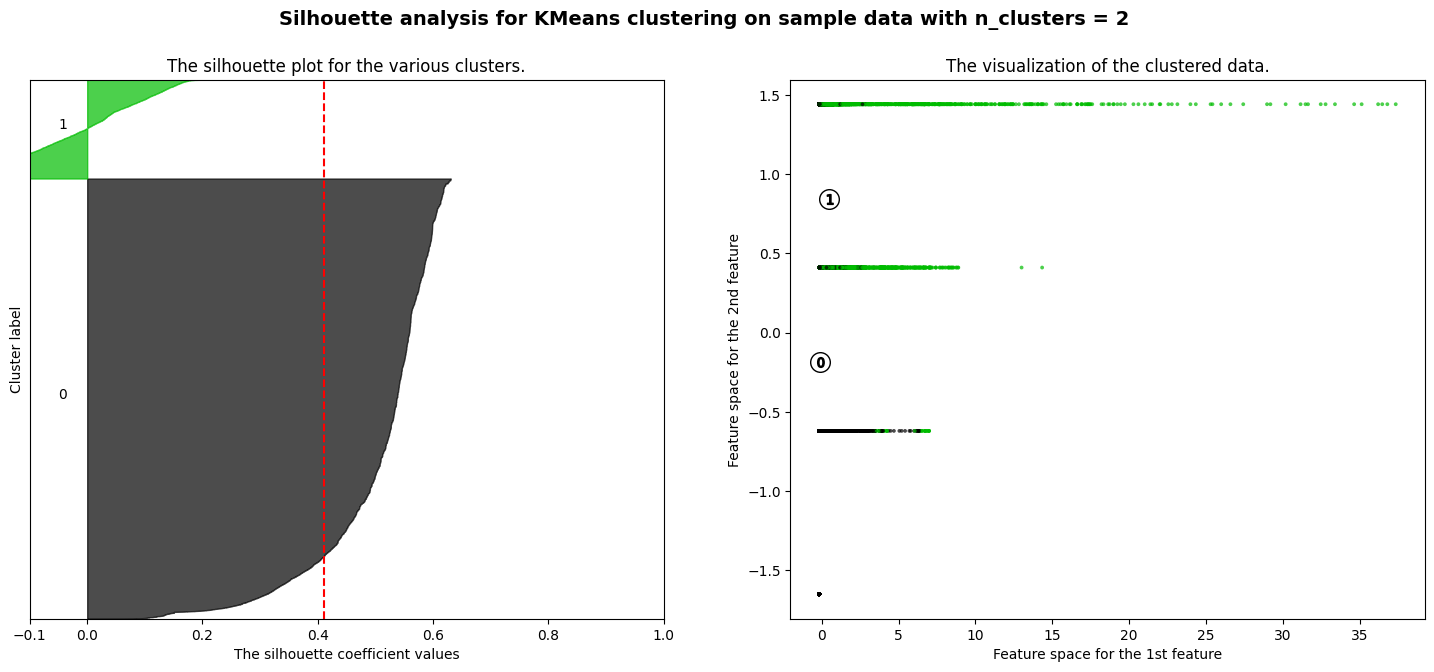

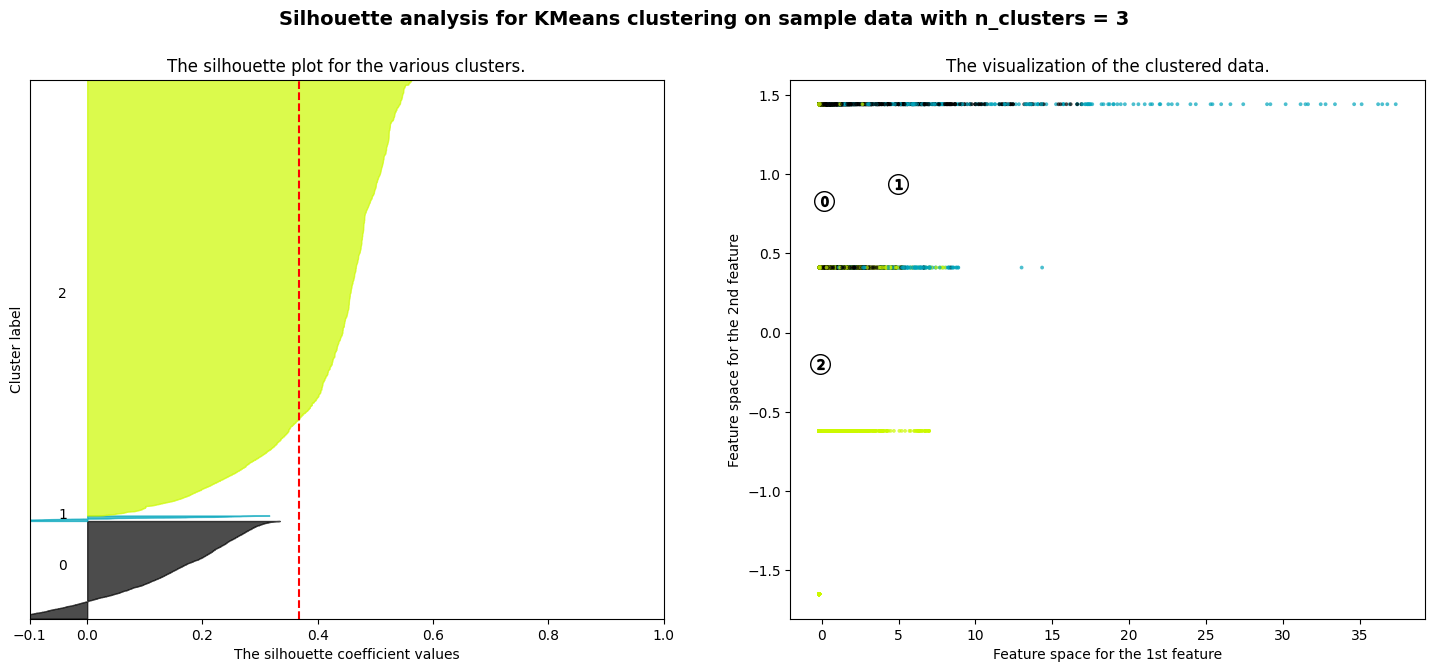

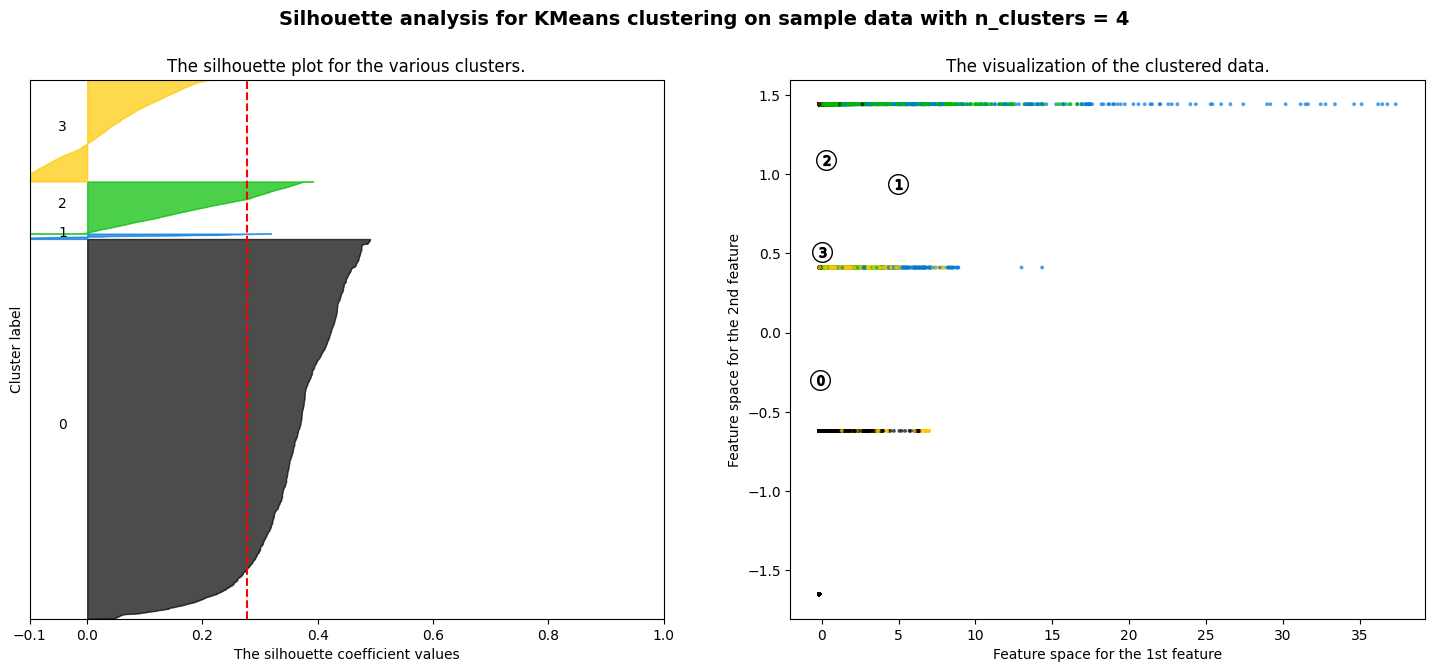

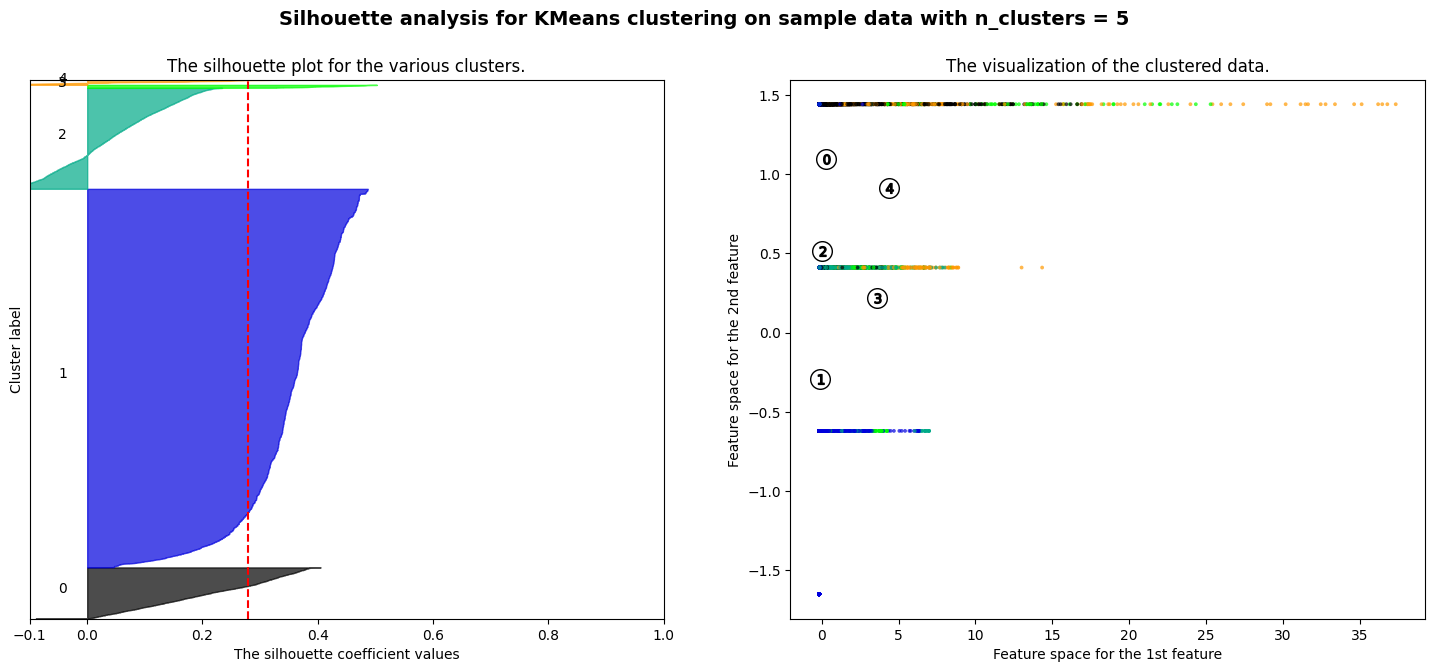

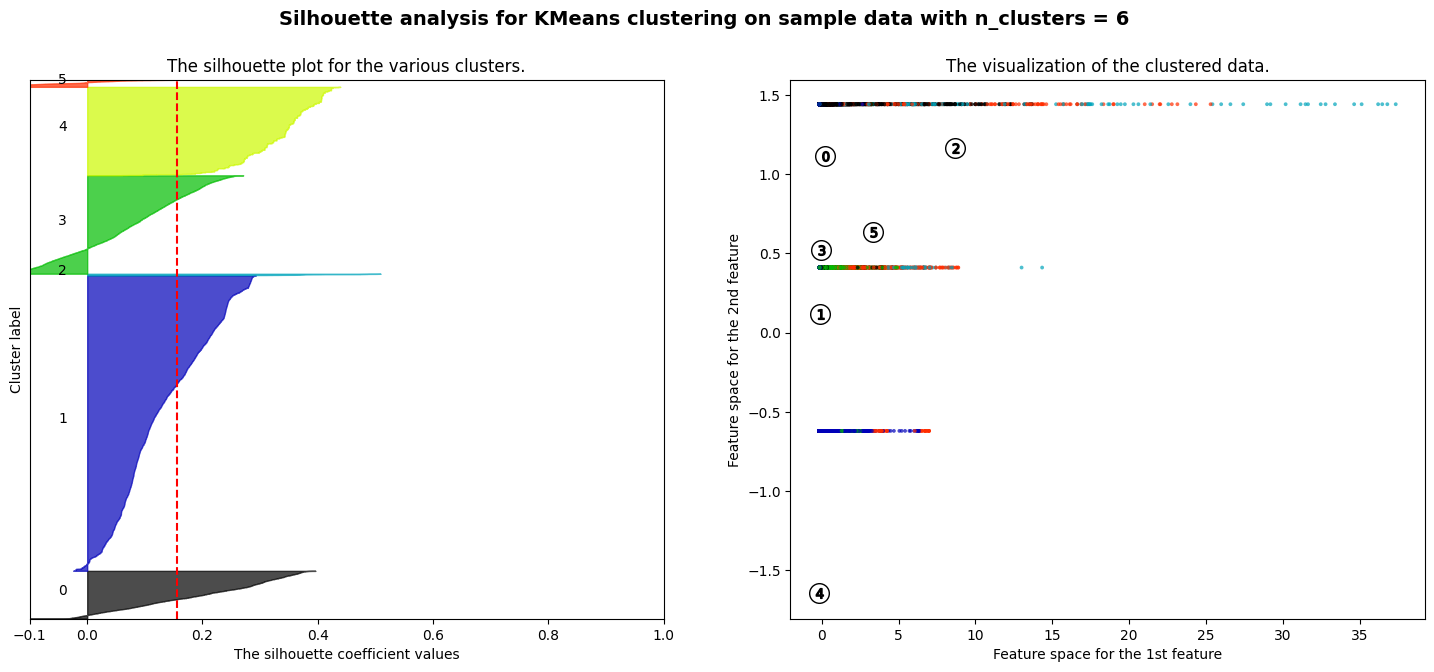

In [12]:
get_silhouette_score(df_train.drop(columns=["Next Week's Deaths"]).values, [2, 3, 4, 5, 6])

O melhor score é quando k = 2

In [13]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df.drop(columns=["Next Week's Deaths"]))
df["cluster"] = clusters

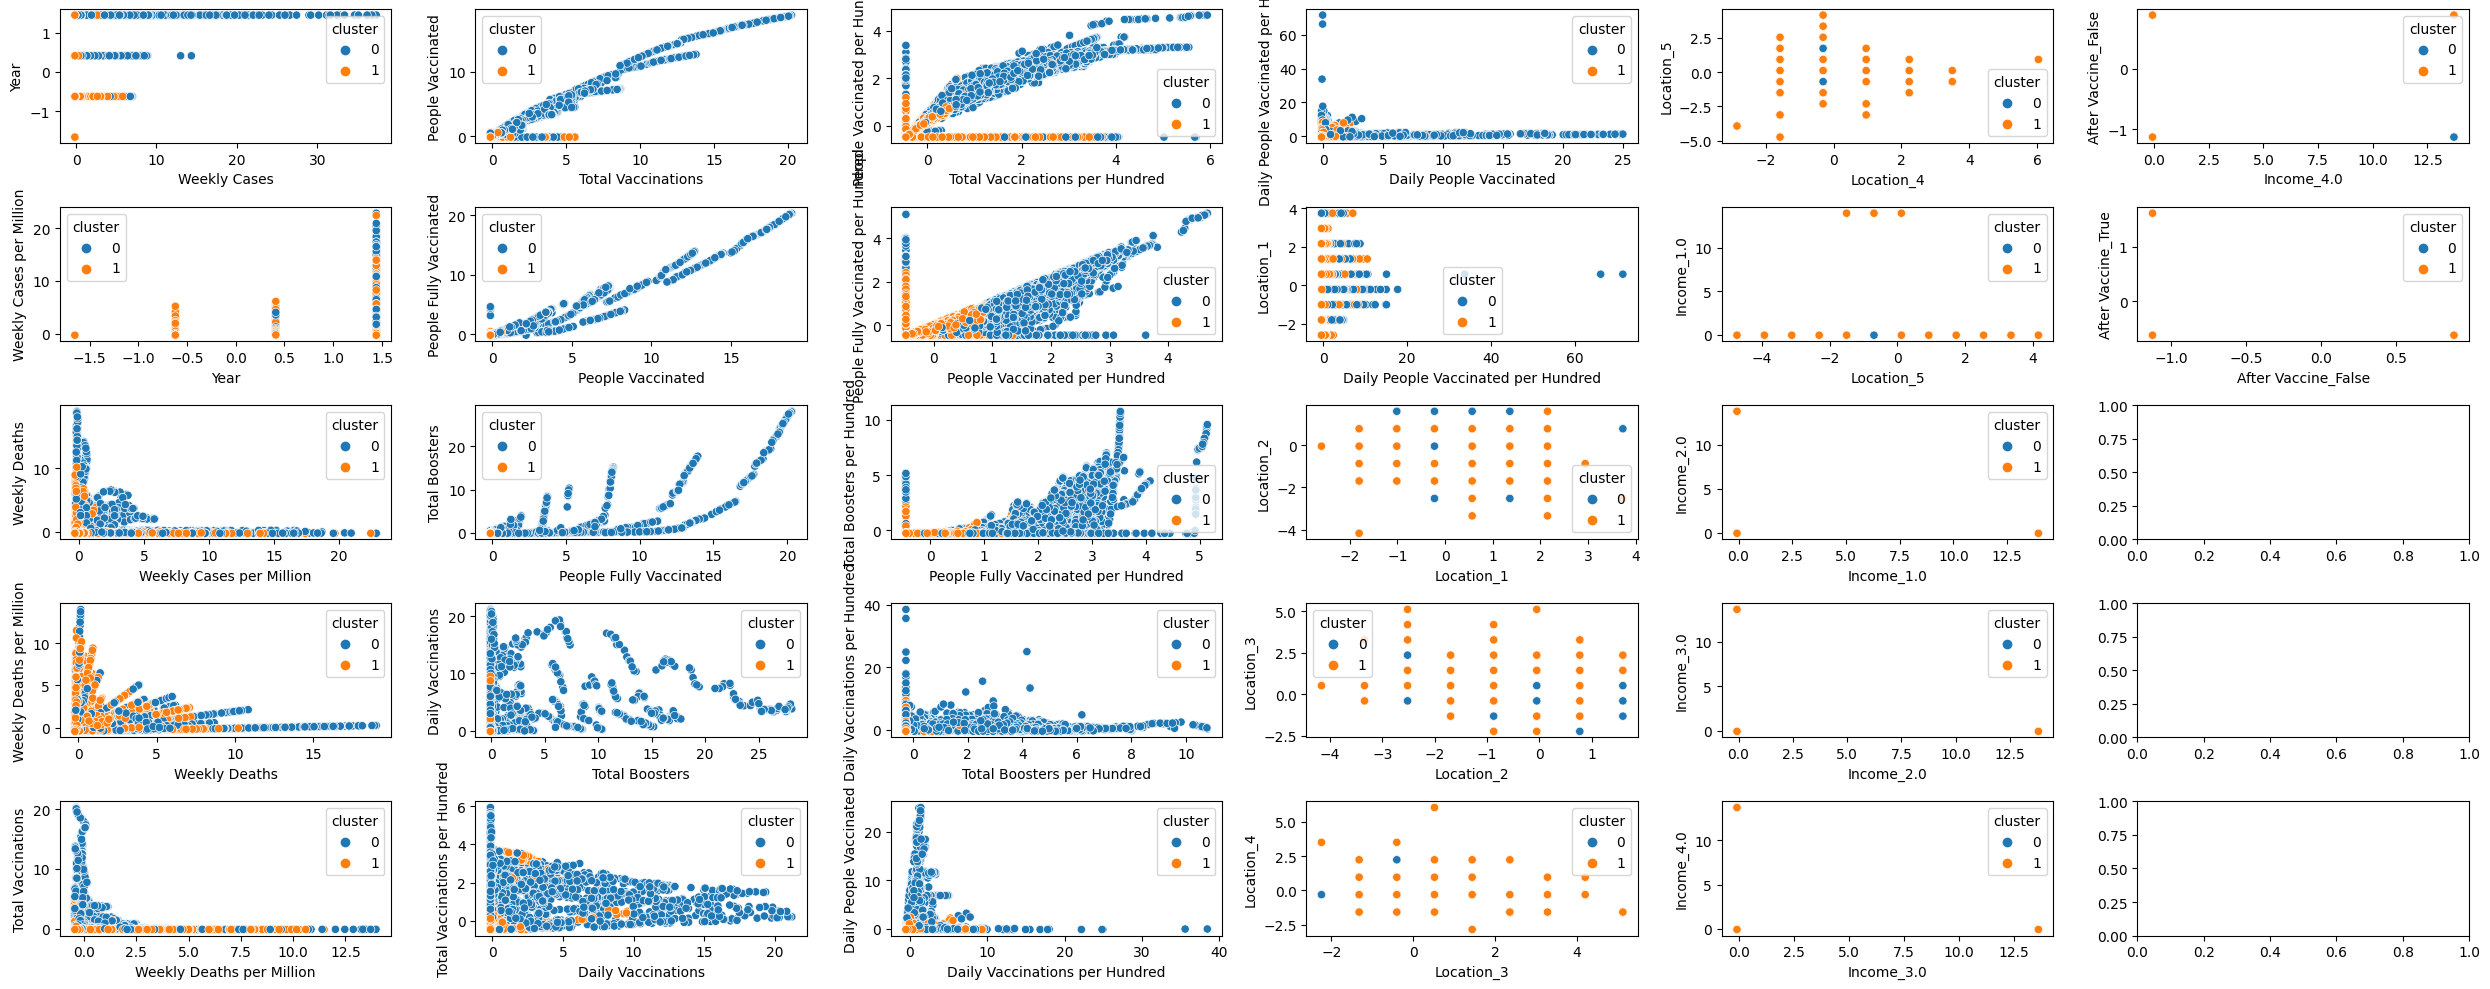

In [14]:
figs, axes = plt.subplots(5,6,figsize=(25,10))
i, j = 0, 0
cols = df_train.drop(columns=["Next Week's Deaths"]).columns
for idx in range(len(cols)-1):
    sns.scatterplot(data=df, x=cols[idx], y=cols[idx + 1], hue='cluster', ax=axes[i, j])
    i+=1
    if i == 5:
        i = 0
        j+=1
plt.tight_layout()

IndexError: index 5 is out of bounds for axis 1 with size 5

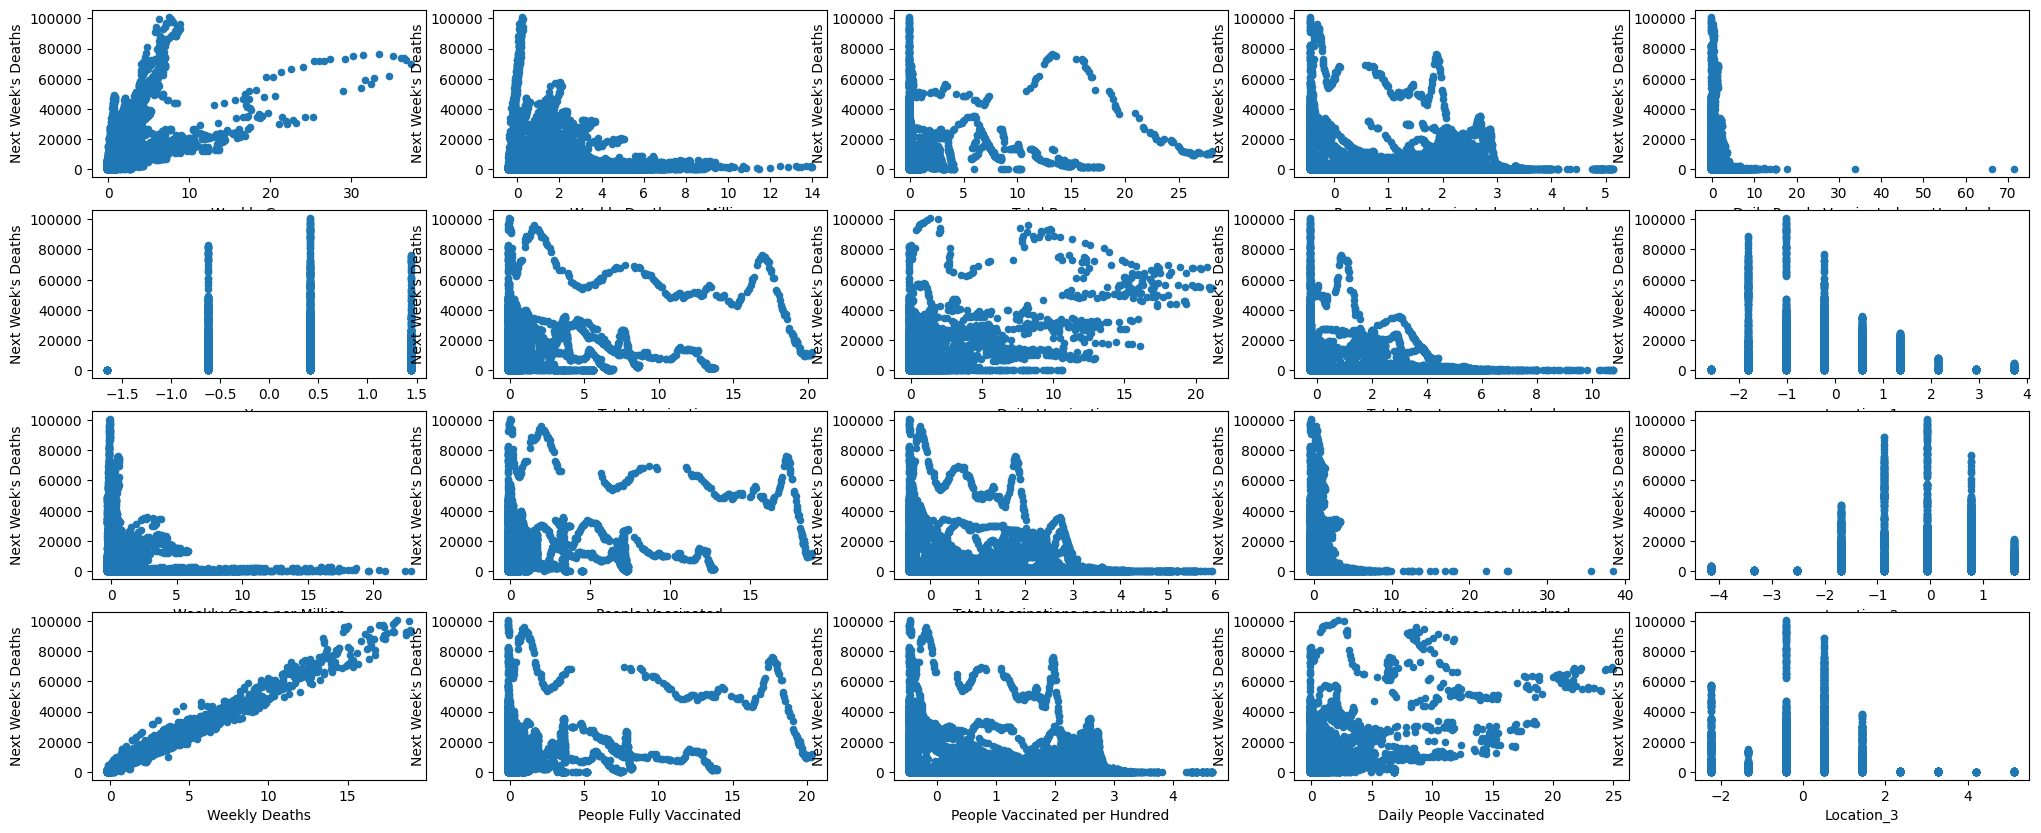

In [15]:
figs, axes = plt.subplots(4,5,figsize=(25,10))
i, j = 0, 0
for col in df_train.drop(columns=["Next Week's Deaths"]).columns:
    df_train[[col, "Next Week's Deaths"]].plot.scatter(x=col, y="Next Week's Deaths", ax=axes[i, j])
    i+=1
    if i == 4:
        i = 0
        j+=1
plt.tight_layout()

# Escolhendo o Melhor modelo pelo conjunto de teste

In [3]:
X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
X_test, y_test = df_test.drop(columns=["Next Week's Deaths"]), df_test["Next Week's Deaths"]
X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

### Linear Regression

In [18]:
lr_model = LinearRegression(**{'fit_intercept': True, 'copy_X': True}, n_jobs=-1)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = lr_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

----- VAL -----
R2:      0.986
MSE:     396845.216
MAE:    149.535
----- TEST -----
R2:      0.987
MSE:     356875.519
MAE:    146.601


O erro no treinamento do Linear Regression foi muito próximo nos entre os conjuntos de teste e validação, o que sugere uma baixa variância. Além nisso, o erro é baixo, o que sugere que é um bom modelo para resolver o nosso problema.

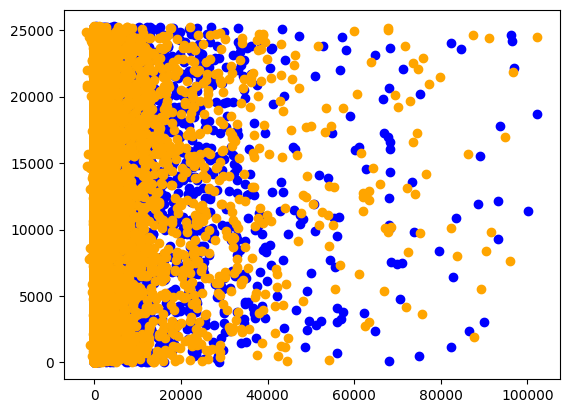

In [19]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

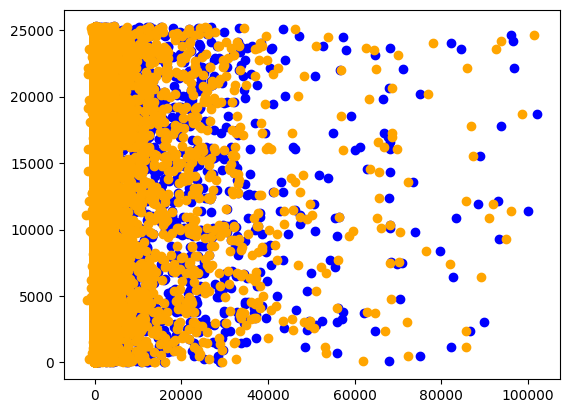

In [20]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred_test)), color='orange')
plt.show()

### Ridge

In [21]:
ridge_model = Ridge(**{'alpha': 100, 'fit_intercept': True, 'copy_X': False, 'solver': 'sag'}, random_state=42)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = ridge_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

----- VAL -----
R2:      0.986
MSE:     396176.803
MAE:    149.362
----- TEST -----
R2:      0.987
MSE:     357261.058
MAE:    146.638


O erro no treinamento do Ridge foi muito próximo nos entre os conjuntos de teste e validação, o que sugere uma baixa variância. Além nisso, o erro é baixo, o que sugere que é um bom modelo para resolver o nosso problema.

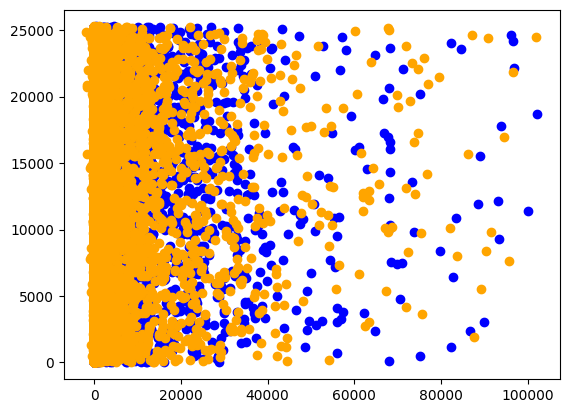

In [22]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

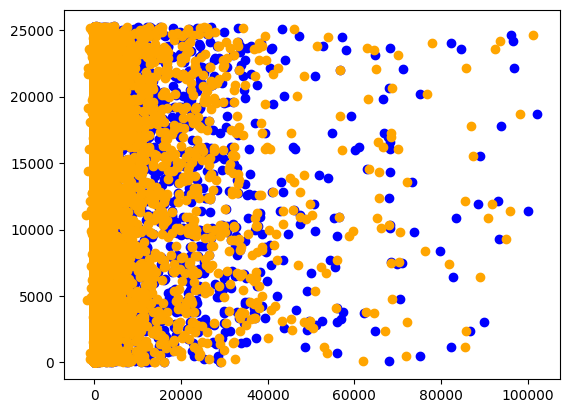

In [23]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred_test)), color='orange')
plt.show()

### SVR

In [5]:
svr_model = SVR(**{'C': 10, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.0}, max_iter=1000)
svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = svr_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


----- VAL -----
R2:      -1.979
MSE:     84090726.454
MAE:    9121.158
----- TEST -----
R2:      -1.998
MSE:     84023073.847
MAE:    9118.105


O R2 do SVR foi negativo, o que sugere que esse talvez não seja um bom modelo para resolver o problema

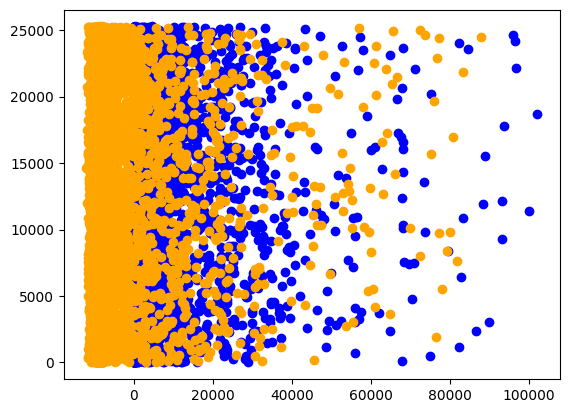

In [6]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

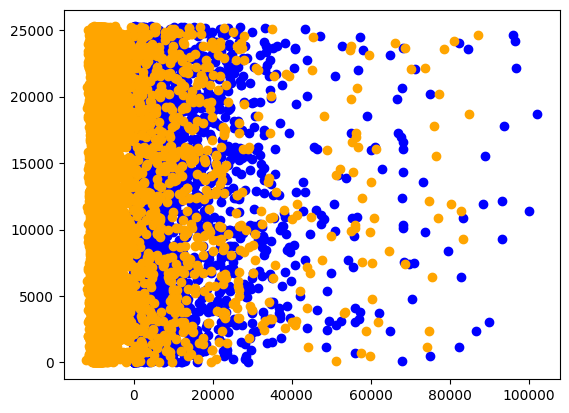

In [7]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred_test)), color='orange')
plt.show()

### Random Forest

In [8]:
rf_model = RandomForestRegressor(**{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

print("----- VAL -----")
print("R2:      {:.3f}".format(r2_score(y_val, y_pred)))
print("MSE:     {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_val, y_pred)))

y_pred_test = svr_model.predict(X_test)

print("----- TEST -----")
print("R2:      {:.3f}".format(r2_score(y_test, y_pred_test)))
print("MSE:     {:.3f}".format(mean_squared_error(y_test, y_pred_test)))
print("MAE:    {:.3f}".format(mean_absolute_error(y_test, y_pred_test)))

----- VAL -----
R2:      0.997
MSE:     83421.692
MAE:    47.723
----- TEST -----
R2:      -1.998
MSE:     84023073.847
MAE:    9118.105


O erro no treinamento do Random foi distante entre os conjuntos de teste e validação, o que sugere alta variância. Como o erro de teste foi muito baixo, o modelo passou por um caso de overfiting. Por isso, vamos descartar o RF e usar os outros modelos.

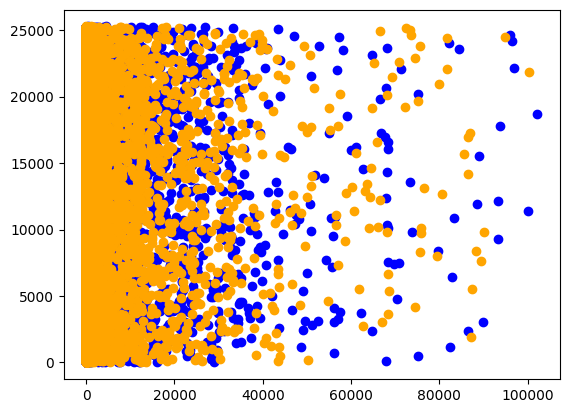

In [9]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred, range(len(y_pred)), color='orange')
plt.show()

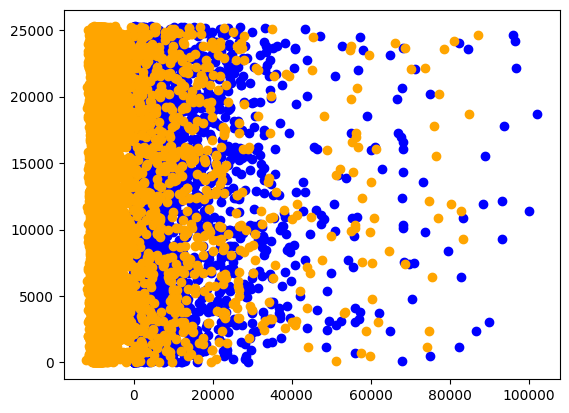

In [10]:
plt.scatter(y_test, range(len(y_test)), color='blue')
plt.scatter(y_pred_test, range(len(y_pred)), color='orange')
plt.show()

# Cross validation

In [10]:
def collect_errors_ridge(X, y, X_test, y_test):
    errors_val, errors_test = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        cv = Ridge(**{'alpha': 100, 'fit_intercept': True, 'copy_X': False, 'solver': 'sag'}, random_state=42)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cv.fit(X_train, y_train)

        y_pred = cv.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        errors_val.append(r2)

        y_pred = cv.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        errors_test.append(r2)

    return errors_val, errors_test

In [11]:
def collect_errors_lr(X, y, X_test, y_test):
    errors_val, errors_test = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        cv = LinearRegression(**{'fit_intercept': True, 'copy_X': True}, n_jobs=-1)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cv.fit(X_train, y_train)

        y_pred = cv.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        errors_val.append(r2)

        y_pred = cv.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        errors_test.append(r2)

    return errors_val, errors_test

In [12]:
# svr_model = SVR(**{'C': 10, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.0})
# ridge_model = Ridge(**{'alpha': 100, 'fit_intercept': True, 'copy_X': False, 'solver': 'sag'}, random_state=42)
# lr_model = LinearRegression(**{'fit_intercept': True, 'copy_X': True}, n_jobs=-1)
# rf_model = RandomForestRegressor(**{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}, random_state=42, n_jobs=-1)


# svr_errors_val, svr_errors_test = collect_errors(svr_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)
ridge_errors_val, ridge_errors_test = collect_errors_ridge(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)
lr_errors_val, lr_errors_test = collect_errors_lr(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)
# rf_errors_val, rf_errors_test = collect_errors(rf_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)

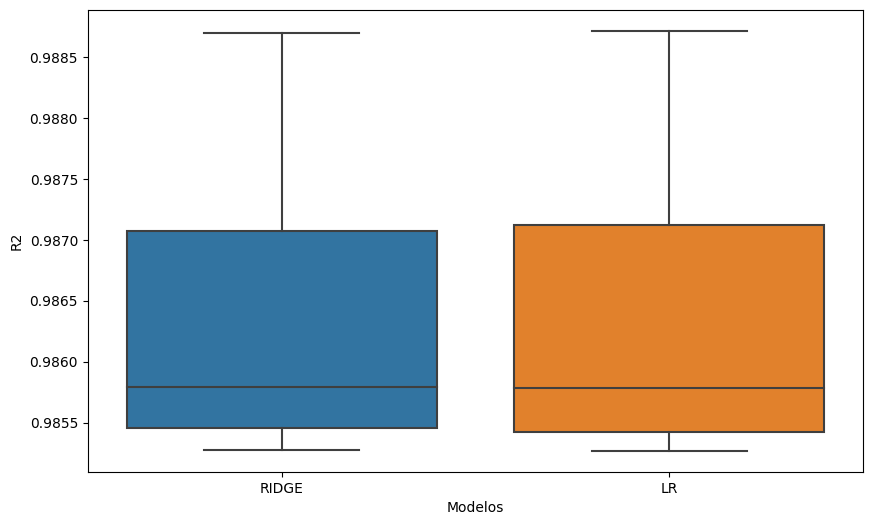

In [13]:
errors_df = pd.DataFrame({
    # 'SVR': svr_errors_val,
    'RIDGE': ridge_errors_val,
    'LR': lr_errors_val,
    # 'RF': rf_errors_val
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.ylabel('R2')
plt.xlabel('Modelos')
plt.show()

In [30]:
np.array([1.01021, 2]).round(2)

array([1.01, 2.  ])

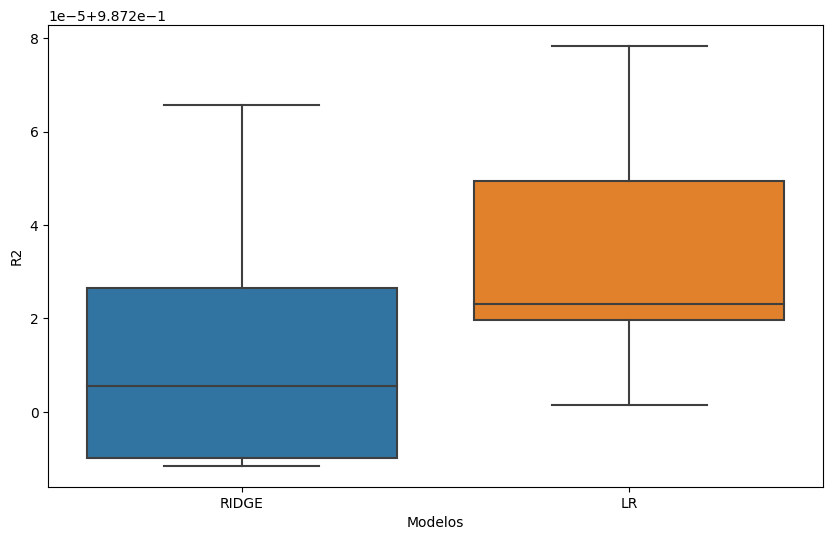

In [36]:
errors_df = pd.DataFrame({
    # 'SVR': svr_errors_test,
    'RIDGE': ridge_errors_test,
    'LR': lr_errors_test,
    # 'RF': rf_errors_test
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.ylabel('R2')
plt.xlabel('Modelos')
plt.show()

#### Teste de Hipótese: o lr é melhor

In [37]:
# hipotese nula: distribuição normal
stats.shapiro(lr_errors_test), stats.shapiro(ridge_errors_test)

(ShapiroResult(statistic=0.9467796087265015, pvalue=0.7141740918159485),
 ShapiroResult(statistic=0.8781247735023499, pvalue=0.3008996248245239))

É uma distribuição normal.

In [38]:
stats.ttest_rel(lr_errors_test, ridge_errors_test, alternative="greater"), stats.ttest_rel(lr_errors_val, ridge_errors_val, alternative="greater")

(TtestResult(statistic=4.856649315338881, pvalue=0.004149690344946414, df=4),
 TtestResult(statistic=0.39346249830519914, pvalue=0.3570247015242606, df=4))

In [40]:
stats.ttest_rel(ridge_errors_test, lr_errors_test, alternative="two-sided"), stats.ttest_rel(ridge_errors_val, lr_errors_val, alternative="two-sided")

(TtestResult(statistic=-4.856649315338881, pvalue=0.008299380689892827, df=4),
 TtestResult(statistic=-0.39346249830519914, pvalue=0.7140494030485212, df=4))

Pelo teste de hipótese, vemos que os modelos têm erros estatisticamente iguais.

# Salvando modelo

In [41]:
model = LinearRegression(**{'fit_intercept': True, 'copy_X': True}, n_jobs=-1)
model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))

LinearRegression(n_jobs=-1)

In [42]:
joblib.dump(model, 'prod_model.pkl')

['prod_model.pkl']

In [47]:
test = df_test.sample(n=1)

In [48]:
test.drop(columns=["Next Week's Deaths"]).values

array([[-0.00780999,  0.41073615,  0.01019074,  0.13420779,  0.664905  ,
        -0.13138404, -0.12870815, -0.12098973, -0.09076258,  0.36131824,
        -0.45460783, -0.47667697, -0.44810676, -0.26483611,  3.66606401,
         0.86114141,  5.80604221,  0.56813726, -1.69545159, -0.40005454,
        -0.30660269, -2.3141746 , -0.07167211, -0.07244861, -0.07343516,
        -0.07294352,  0.88850864, -0.62147068]])

In [49]:
test["Next Week's Deaths"]

20161    1490.0
Name: Next Week's Deaths, dtype: float64